# Classificazione Trento

In [133]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, BoundaryNorm, TwoSlopeNorm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import pandas as pd
import numpy as np
import seaborn as sns

import geopandas as gpd
import json
from shapely.geometry import Point, shape, Polygon

from sklearn import datasets
from sklearn.model_selection import cross_val_score, ParameterGrid
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.metrics import matthews_corrcoef,confusion_matrix, ConfusionMatrixDisplay,accuracy_score, classification_report
from sklearn.metrics import f1_score

pd.set_option('display.max_rows', 250)
rdm_st = 89 # utile per poter avere risultati riproducibili

Carico il file creato in fase EDA

In [136]:
df = pd.read_csv(r'C:\Users\Francesco\Desktop\UniTN\datascience\progetto\TanTupo\trentino_dataset_class.xls').copy()

In [137]:
df

,cellId,day,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,...,DEC,LU,MA,ME,GI,VE,SA,DO,TargetReg,TargetClas
0,4381,1,1,39,1,1.239065,11.9,17.5,15.665909,0,...,0,0,0,0,0,1,0,0,1.247901,0
1,4381,1,0,39,1,1.380110,13.1,14.9,13.850000,0,...,0,0,0,0,0,1,0,0,1.380259,0
2,4381,2,1,39,1,1.247901,11.0,16.0,13.836364,0,...,0,0,0,0,0,0,1,0,1.195697,0
3,4381,2,0,39,1,1.380259,10.6,12.5,11.780000,0,...,0,0,0,0,0,0,1,0,1.387678,0
4,4381,3,1,39,1,1.195697,13.9,18.8,15.772727,0,...,0,0,0,0,0,0,0,1,1.798402,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6355,5902,28,0,438,2,10.753951,4.0,4.6,4.255000,2,...,1,0,0,0,0,0,1,0,10.523905,0
6356,5902,29,1,438,2,9.546638,4.4,7.0,5.718182,1,...,1,0,0,0,0,0,0,1,8.317639,0
6357,5902,29,0,438,2,10.523905,5.7,6.2,5.960000,0,...,1,0,0,0,0,0,0,1,11.160029,0
6358,5902,30,1,438,2,8.317639,1.2,8.2,4.838636,3,...,1,1,0,0,0,0,0,0,9.000693,0


Ora togliamo le colonne che non ci servono:
1. cellId -> sono numeri ordinati, e come gia' spiegato in EDA questo potrebbe portare a classificazioni fasulle, interpretando una cella con cellId piu alto piu importante rispetto a una con cellId piu' basso, cosa che non deve essere a priori
2. day -> stesso motivo di cellId
3. TargetReg -> l'ho usata solo per creare la colonna TargetClas che ci serve qua

In [141]:
del df['cellId']
del df['day']
del df['TargetReg']

#Rinomino la colonna TargetClas in target
df = df.rename(columns={'TargetClas': 'target'})

In [142]:
# Tolgo i sabati e le domeniche, voglio solo analizzare giorni infrasettimanali
df = df[(df['SA'] != 1) & (df['DO'] != 1)]
del df['SA']
del df['DO']

In [145]:
df

,fascia_giorno,UBIC_CELL,n_linee,energy,temp_min,temp_max,temp_mean,tweet_count,precip_mm,NOV,DEC,LU,MA,ME,GI,VE,target
0,1,39,1,1.239065,11.9,17.5,15.665909,0,0.0,1,0,0,0,0,0,1,0
1,0,39,1,1.380110,13.1,14.9,13.850000,0,0.0,1,0,0,0,0,0,1,0
6,1,39,1,1.798402,8.5,10.4,9.340909,0,7.2,1,0,1,0,0,0,0,0
7,0,39,1,1.689786,8.4,8.6,8.525000,0,1.2,1,0,1,0,0,0,0,0
8,1,39,1,1.657573,9.0,15.3,12.125000,0,0.0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6351,0,438,2,10.469691,4.2,6.3,5.240000,2,0.8,0,1,0,0,0,1,0,0
6352,1,438,2,8.829274,3.2,9.8,7.304545,5,0.0,0,1,0,0,0,0,1,0
6353,0,438,2,10.922511,1.0,2.7,1.935000,2,0.0,0,1,0,0,0,0,1,0
6358,1,438,2,8.317639,1.2,8.2,4.838636,3,0.0,0,1,1,0,0,0,0,0


Dato che abbiamo scelto la mediana come soglia per cella ad alta energia, verifichiamo che le popolazioni hanno la stessa dimensione:

In [148]:
print(df['target'].value_counts())

target
1    2266
0    2186
Name: count, dtype: int64


Iniziamo a suddividere il dataset in training, validation e test, con percentuali 60-20-20

In [151]:
df_train, df_valid_test = train_test_split(df, test_size = 0.4, random_state=rdm_st)
df_valid, df_test = train_test_split(df_valid_test, test_size = 0.5, random_state=rdm_st)

Dividiamo le features dal target

In [154]:
x_train = df_train.drop(columns='target')
y_train = df_train['target']

x_valid = df_valid.drop(columns='target')
y_valid = df_valid['target']

x_test = df_test.drop(columns='target')
y_test = df_test['target']

Successivamente si proveranno piu' modelli di classificazione, e si scegliera' in seguito il migliore.

## Random Forest

In [158]:
model_rf = RandomForestClassifier(random_state = rdm_st)

Quando si usano le Random Forest non è necessario riscalare le features.
Faccio il training:

In [161]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(random_state=89)

E ora trovo i valori previsti su il set di validazione

In [164]:
y_pred1 = model_rf.predict(x_valid)

Validation Accuracy: 0.9764044943820225
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       407
           1       0.98      0.98      0.98       483

    accuracy                           0.98       890
   macro avg       0.98      0.98      0.98       890
weighted avg       0.98      0.98      0.98       890



Text(0.5, 1.0, 'Matrice di confusione: RF classifier su validation set')

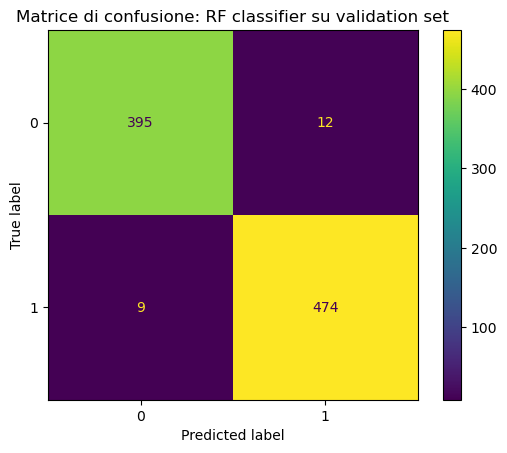

In [166]:
print("Validation Accuracy:", accuracy_score(y_valid, y_pred1))
print(classification_report(y_valid, y_pred1))

ConfusionMatrixDisplay.from_estimator(model_rf, x_valid, y_valid)
plt.title('Matrice di confusione: RF classifier su validation set')

classification_report ci da' varie informazioni sulla bonta' della nostra classificazione: ci interessano principalmente i vari valori degli estimatori solamente delle prime due righe, che sono le nostre classi 0 (bassa energia) e 1 (alta energia)

In [169]:
y_pred2 = model_rf.predict(x_train)
print("Train Accuracy:", accuracy_score(y_train, y_pred2))
print(classification_report(y_train, y_pred2))
print('matrice di confusione: RF classifier su training set')
print(confusion_matrix(y_train, y_pred2))

Train Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1331
           1       1.00      1.00      1.00      1340

    accuracy                           1.00      2671
   macro avg       1.00      1.00      1.00      2671
weighted avg       1.00      1.00      1.00      2671

matrice di confusione: RF classifier su training set
[[1331    0]
 [   0 1340]]


Per comodita' e per snellire il notebook, stamperemo matrici di confusione con print() quando riteniamo che queste siano di seconda importanza. Se le si vuole vedere tutte nella loro forma grafica, basta sostituire le linee di codice

print('matrice di confusione: RF classifier su training set')
print(confusion_matrix(y_valid, y_predNR))

con

ConfusionMatrixDisplay.from_estimator(model_rf, x_valid, y_valid)
plt.title('Matrice di confusione: RF classifier su training set')

Notiamo che il modello riesce a fittare perfettamente il set di training e questo e' probabilmente dovuto ad un totale overfitting. E' un buon punto di partenza, proviamo con GridSearchCV

In [172]:
def best_model (model, param_grid, x,y, cv=10, scoring='accuracy'):
    """
    funzione che prende in input
    -> model: modello di classificazione (es RandomForestClassifier)
    -> param_grid: dizionario usato da GridSearchCV, in cui metto
                'nome_parametro1': [valore 1, valore 2, ...]
                'nome_parametro2': [valore 1, valore 2, ...]
                ...
                ...
    -> x e y: sono il set di training
    -> cv: e' il numero di fold che viene usato
    -> scoring: e' la metrica di riferimento da minimizzare, come accuracy(di base), f1, precision, recall
    OUTPUT
    -> _best_model: e' il modello ottimizzato tra i vari parametri scelti
    -> _best_param: i parametri migliori trovati
                
    """


    
    grid_model = GridSearchCV(model,
                              param_grid=param_grid,
                              scoring=scoring,
                              cv=cv,
                              n_jobs=-1, # cosi uso tutti cores del pc, piu veloce
                              error_score=0
                             )

    grid_model.fit(x,y)

    _best_param = grid_model.best_params_
    _best_model = grid_model.best_estimator_

    return _best_model, _best_param

ora definisco i parametri tra cui voglio cercare:

In [175]:
cv = 5

param_grid = {
    'n_estimators': [50, 75, 100, 130],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [2, 3, 5]
}

Proviamo ad allenare i modelli usando tre metriche diverse

In [178]:
model_rf_acc, param_rf_acc = best_model(RandomForestClassifier(), param_grid, x_train, y_train, cv, 'accuracy')
model_rf_f1, param_rf_f1 = best_model(RandomForestClassifier(), param_grid, x_train, y_train, cv, 'f1')
model_rf_mcc, param_rf_mcc = best_model(RandomForestClassifier(), param_grid, x_train, y_train, cv, 'matthews_corrcoef')

C:\Users\Francesco\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\Francesco\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Ora che ho trainato il modello provo a vedere i risultati

In [181]:
print(param_rf_acc)
print(param_rf_f1)
print(param_rf_mcc)

{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 50}
{'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 75}
{'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}


Guardo e confronto i tre modelli

In [184]:
y_pred3 = model_rf_acc.predict(x_valid)
y_pred4 = model_rf_acc.predict(x_train)

y_pred5 = model_rf_f1.predict(x_valid)
y_pred6 = model_rf_f1.predict(x_train)

y_pred7 = model_rf_mcc.predict(x_valid)
y_pred8 = model_rf_mcc.predict(x_train)

In [186]:
print('ACCURACY VALIDAZIONE')
print("Train Accuracy:", accuracy_score(y_valid, y_pred3))
print(classification_report(y_valid, y_pred3))
print('matrice di confusione: RF classifier ottimizzato accuracy su validation set')
print(confusion_matrix(y_valid, y_pred3))

ACCURACY VALIDAZIONE
Train Accuracy: 0.9752808988764045
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       407
           1       0.97      0.98      0.98       483

    accuracy                           0.98       890
   macro avg       0.98      0.97      0.98       890
weighted avg       0.98      0.98      0.98       890

matrice di confusione: RF classifier ottimizzato accuracy su validation set
[[394  13]
 [  9 474]]


In [188]:
print('ACCURACY TRAIN')
print("Train Accuracy:", accuracy_score(y_train, y_pred4))
print(classification_report(y_train, y_pred4))
print('matrice di confusione: RF classifier ottimizzato accuracy su training set')
print(confusion_matrix(y_train, y_pred4))

ACCURACY TRAIN
Train Accuracy: 0.992137776113815
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1331
           1       0.99      0.99      0.99      1340

    accuracy                           0.99      2671
   macro avg       0.99      0.99      0.99      2671
weighted avg       0.99      0.99      0.99      2671

matrice di confusione: RF classifier ottimizzato accuracy su training set
[[1320   11]
 [  10 1330]]


In [190]:
print('F1 VALIDAZIONE')
print("Train Accuracy:", accuracy_score(y_valid, y_pred5))
print(classification_report(y_valid, y_pred5))
print('matrice di confusione: RF classifier ottimizzato f1 su validation set')
print(confusion_matrix(y_valid, y_pred5))

F1 VALIDAZIONE
Train Accuracy: 0.9752808988764045
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       407
           1       0.98      0.98      0.98       483

    accuracy                           0.98       890
   macro avg       0.98      0.97      0.98       890
weighted avg       0.98      0.98      0.98       890

matrice di confusione: RF classifier ottimizzato f1 su validation set
[[395  12]
 [ 10 473]]


In [192]:
print('F1 TRAIN')
print("Train Accuracy:", accuracy_score(y_train, y_pred6))
print(classification_report(y_train, y_pred6))
print('matrice di confusione: RF classifier ottimizzato f1 su training set')
print(confusion_matrix(y_train, y_pred6))

F1 TRAIN
Train Accuracy: 0.9932609509546986
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1331
           1       0.99      0.99      0.99      1340

    accuracy                           0.99      2671
   macro avg       0.99      0.99      0.99      2671
weighted avg       0.99      0.99      0.99      2671

matrice di confusione: RF classifier ottimizzato f1 su training set
[[1323    8]
 [  10 1330]]


In [194]:
print('MCC VALIDAZIONE')
print("Train Accuracy:", accuracy_score(y_valid, y_pred7))
print(classification_report(y_valid, y_pred7))
print('matrice di confusione: RF classifier ottimizzato mcc su validation set')
print(confusion_matrix(y_valid, y_pred7))

MCC VALIDAZIONE
Train Accuracy: 0.9730337078651685
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       407
           1       0.97      0.98      0.98       483

    accuracy                           0.97       890
   macro avg       0.97      0.97      0.97       890
weighted avg       0.97      0.97      0.97       890

matrice di confusione: RF classifier ottimizzato mcc su validation set
[[393  14]
 [ 10 473]]


In [196]:
print('MCC TRAIN')
print("Train Accuracy:", accuracy_score(y_train, y_pred8))
print(classification_report(y_train, y_pred8))
print('matrice di confusione: RF classifier ottimizzato mcc su training set')
print(confusion_matrix(y_train, y_pred8))

MCC TRAIN
Train Accuracy: 0.9951329090228379
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1331
           1       1.00      0.99      1.00      1340

    accuracy                           1.00      2671
   macro avg       1.00      1.00      1.00      2671
weighted avg       1.00      1.00      1.00      2671

matrice di confusione: RF classifier ottimizzato mcc su training set
[[1328    3]
 [  10 1330]]


In questo caso vediamo in generale che abbiamo meno overfitting, ma non notiamo un miglioramento sostanziale nel predire il set di validazione. Cio' nonostante, seppur di poco, il modello che utilizza accuracy come scoring pare essere il migliore.

NB! questo risultato si e' notato ripetendo il training piu' volte. Puo' capitare ogni tanto che lo scoring migliore sia uno diverso da accuracy, ma ripetendo il fit piu' volte accuracy risulta performare meglio il piu' delle volte. In ogni caso, la differenza e' sempre minima.

In [199]:
model_rf_best = model_rf_acc
param_rf_best = param_rf_acc

E' interessante vedere quali sono pesi dei vari parametri:

In [202]:
# Metto i pesi delle features in un dataframe
model_rf_best_df = pd.DataFrame({'feature' : x_train.columns, 'peso':model_rf_best.feature_importances_})

In [204]:
model_rf_best_df

,feature,peso
0,fascia_giorno,0.002434
1,UBIC_CELL,0.185149
2,n_linee,0.118366
3,energy,0.611654
4,temp_min,0.014099
5,temp_max,0.011027
6,temp_mean,0.012013
7,tweet_count,0.027620
8,precip_mm,0.004954
9,NOV,0.001069


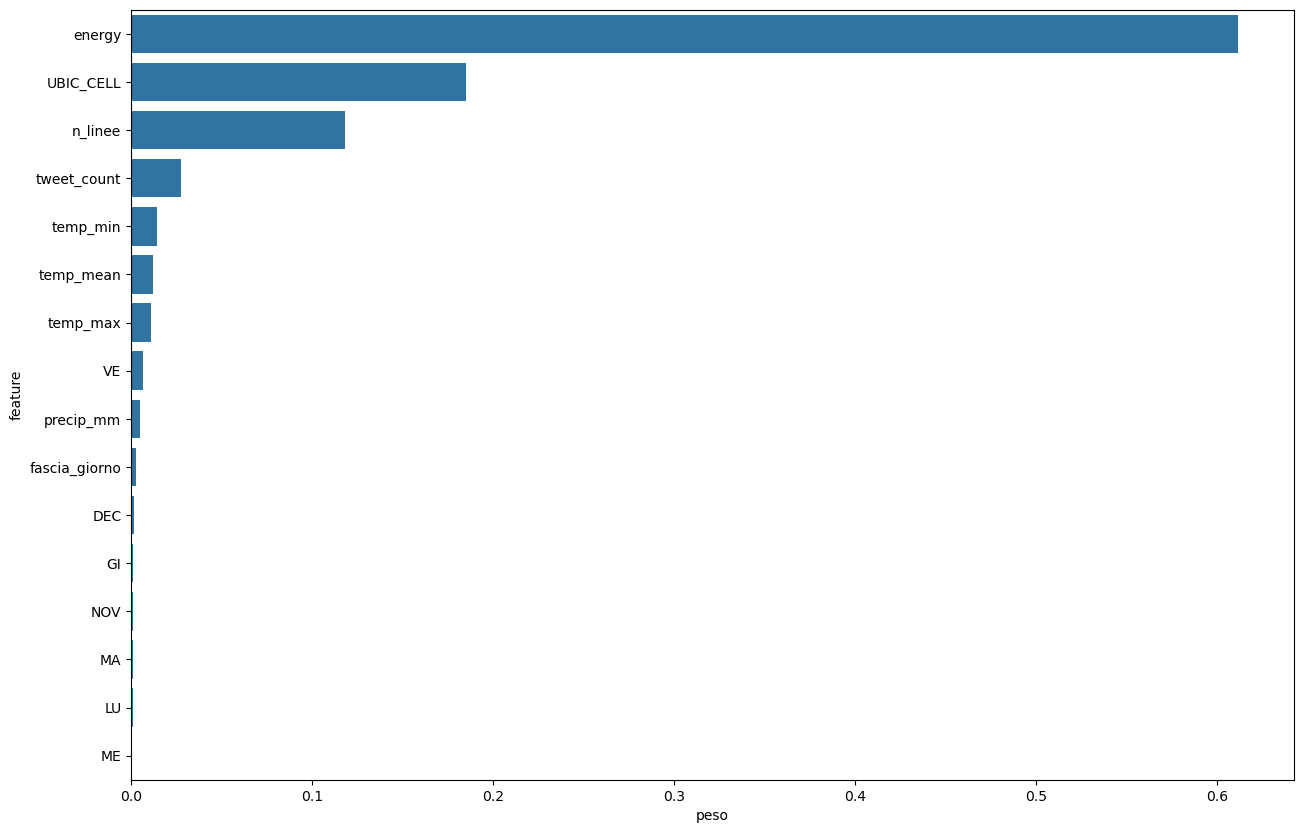

In [206]:
fig, ax = plt.subplots(figsize=(15, 10))
df_plot = model_rf_best_df.sort_values('peso', ascending=False).copy()
sns.barplot(x='peso', y='feature', data=model_rf_best_df, order=df_plot['feature'] )
del df_plot

Come ci si aspetta, le features piu' importanti sono i valori energetici, il numero totale di ubicazioni nella cella e numero di linee collegate alla cella. Questa cosa ha senso perche' una cella che oggi consuma tanto, magari perche' corrisponde a una zona con molte fabbriche o abitazioni, e' probabile che consumera' molto anche domani. Il numero di ubicazioni influisce in maniera analoga: se ho tante ubicazioni in una cella, e' molto probabile che consumera' di piu' di una cella con meno ubicazioni. Stesso discordo per il numero di linee.
Le temperature minima, media e massima influiscono bene o male allo stesso modo, anche se quella minima e' leggermente piu' pesante. Questo potrebbe spiegarsi con il fatto che a temperature piu' basse vengono usati maggiormente sistemi di riscaldamento.
E' interessante notare come il numero di tweets influisca notevolmente di piu, di circa un fattore 2, della temperatura minima.
Infine, si puo' vedere che le precipitazioni influiscono realtivamente poco, cosi come le fascie giornaliere, giorno o sera, e i giorni della settimana. L'ultimo appunto interessante e' che il giorno piu' influente e' il venerdi': un'ipotesi per spiegare questo risultato e' il fatto che il venerdi e' l'ultimo giorno di lavoro, il giorno dopo molte meno aziende e persone lavorano e quindi c'è un calo drastico nei consumi medi. Inoltre, potrebbero esserci picchi di consumo il venerdi per attivita' preparatorie per il weekend, come riscaldamento anticipato, pulizie, staccacio e spostamenti merci.

Scelgo allora come modello da usare model_rf_acc. 

Ora che ho scelto il modello voglio trovare la Treshold migliore per ottimizzare il 
true positive rate. Per farlo inizio con tracciare la ROC e calcolare la AUROC del modello.

Per farlo mi serve inizialmente calcolare la probabilita' stimata dal modello per la classe 1:

In [210]:
y_prob_rf_roc = model_rf_best.predict_proba(x_test)[:,1]

In [212]:
fpr_rf, tpr_rf, roc_th = roc_curve(y_test, y_prob_rf_roc)
roc_auc_mcc = auc(fpr_rf, tpr_rf)

Posso calcolare allora la miglior treshold come quella che minimizza la distanza dal punto ottimale (TPR, FPR) = (1,0)

In [215]:
distance = np.sqrt((fpr_rf)**2 + (1-tpr_rf)**2)
index_min = np.argmin(distance)
best_roc_th = roc_th[index_min]

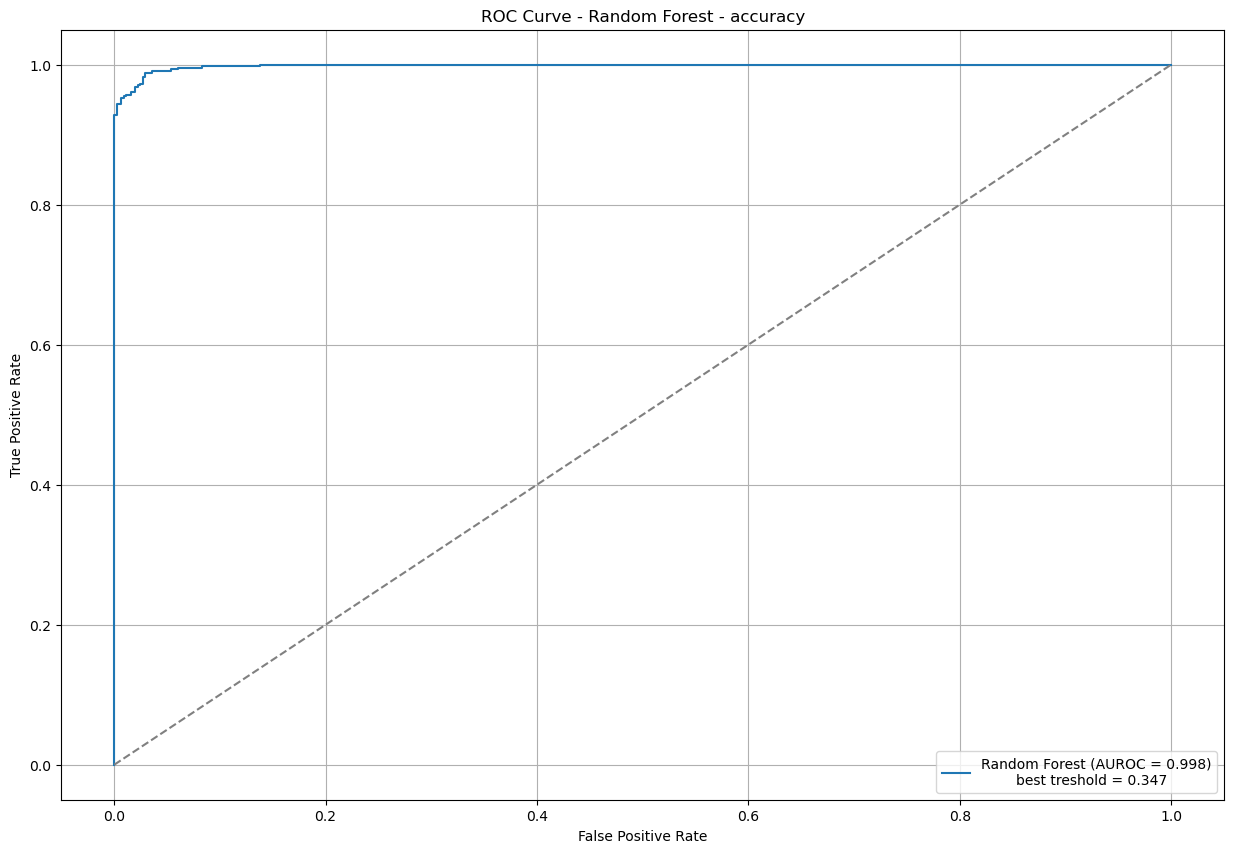

In [217]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUROC = {roc_auc_mcc:.3f})\n\
        best treshold = {best_roc_th:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest - accuracy')
plt.legend()
plt.grid()

La ROC del modello e' decisamente buona: riusciamo ad arrivare vicini al punto ottimale e la AUROC e' molto vicina a 1.

A questo punto possiamo provare a utilizzare la treshold ottimale per il nostro modello

In [220]:
y_pred_rf = (y_prob_rf_roc >= best_roc_th).astype(int)

RF con miglior treshold: 0.9797979797979798
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       448
           1       0.97      0.99      0.98       443

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



Text(0.5, 1.0, 'Matrice di confusione: RF classifier con treshold migliore su test set')

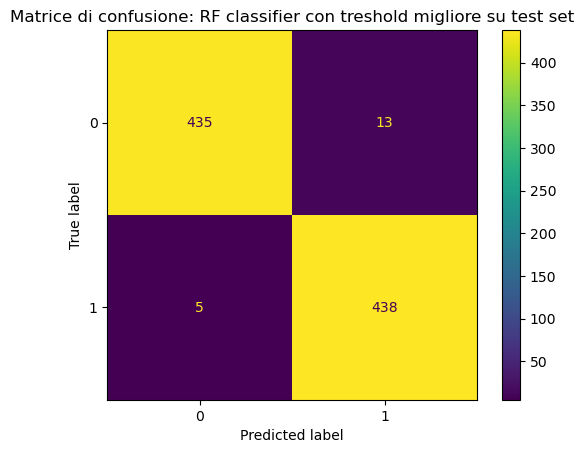

In [222]:
print("RF con miglior treshold:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)
plt.title('Matrice di confusione: RF classifier con treshold migliore su test set')

Notiamo che ora il nostro modello generalizza molto meglio di prima.

NB! anche in questo caso si parla di un risultato in media: abbiamo notato che il modello a volte non migliora o peggiora pure di poco. in genere pero' si nota un miglioramento.

Passiamo ora a vedere la curva precision-recall

In [226]:
y_pred_rf_prrec = model_rf_best.predict_proba(x_test)[:,1]
pr_rf, rec_rf, prrec_th = precision_recall_curve(y_test, y_pred_rf_prrec)

Anche qui trovo la soglia migliore, ovvero quella che minimizza la distanza dal punto ottimale (REC, PREC) = (1,1)

In [229]:
distance = np.sqrt((1-rec_rf)**2 + (1-pr_rf)**2)
index_min = np.argmin(distance)
best_prrec_th = prrec_th[index_min]

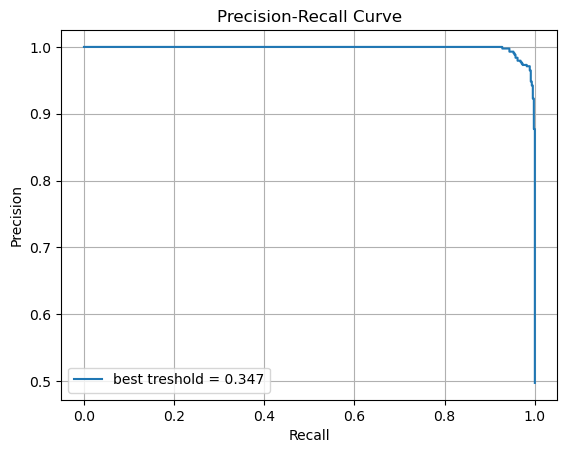

In [231]:
plt.plot(rec_rf, pr_rf, label=f'best treshold = {best_prrec_th:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Notiamo quindi che la soglia migliore rimane sempre la stessa

Ora che abbiamo modello e treshold migliori, rieffettuiamo il training del modello sull'insieme di training e validazione assieme:

In [235]:
x_valut = pd.concat([x_train, x_valid])
y_valut = pd.concat([y_train, y_valid])

In [237]:
model_rf_final = RandomForestClassifier(**param_rf_best, random_state=rdm_st)
model_rf_final.fit(x_valut, y_valut)

y_prob_fin = model_rf_final.predict_proba(x_test)[:,1]
y_pred_fin = (y_prob_fin >= best_roc_th).astype(int)

RF MCC con miglior treshold su train e validazione: 0.9797979797979798
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       448
           1       0.97      0.99      0.98       443

    accuracy                           0.98       891
   macro avg       0.98      0.98      0.98       891
weighted avg       0.98      0.98      0.98       891



Text(0.5, 1.0, 'Matrice di confusione: RF classifier train + validazione con treshold migliore su test set')

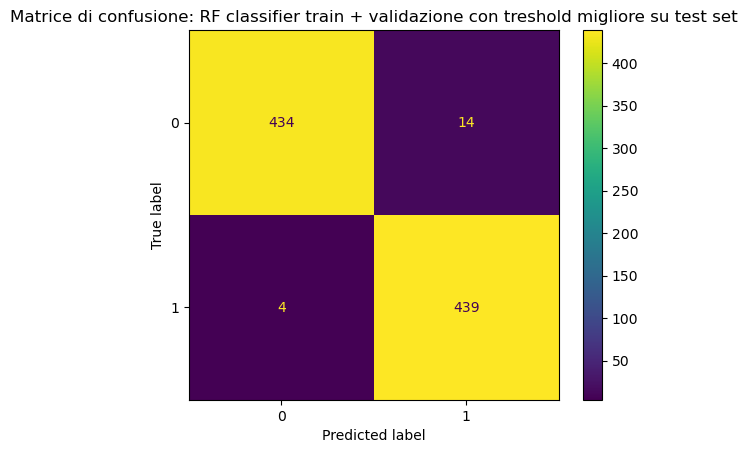

In [239]:
print("RF MCC con miglior treshold su train e validazione:", accuracy_score(y_test, y_pred_fin))
print(classification_report(y_test, y_pred_fin))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fin)
plt.title('Matrice di confusione: RF classifier train + validazione con treshold migliore su test set')

Si nota che in genere la performance del modello migliora rispetto al caso iniziale. Come gia' detto questo e' solo un risultato medio, rieffettuando piu' volte il fit il modello puo' non migliorare o peggiorare le sue performance, ma in genere le migliora.

# Regressore Logistico

E' importante sottolineare che il Regressore logistico ha prestazioni generalmente inferiori rispetto alle Random Forest se le relazioni tra le features non sono tutte lineari. il regressore logistico e' infatti un modello lineare e non riesce dunque a classificare bene se lo spazio delle features non e' linearmente separabile, a differenza delle Random Forest che non sono modelli lineari. Nel nostro caso ci aspettiamo quindi una prestazione peggiore delle Random Forest, ma vale la pena provare.

LR: 0.9606741573033708
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       407
           1       0.96      0.96      0.96       483

    accuracy                           0.96       890
   macro avg       0.96      0.96      0.96       890
weighted avg       0.96      0.96      0.96       890



Text(0.5, 1.0, 'Matrice di confusione: LR classifier su validation set')

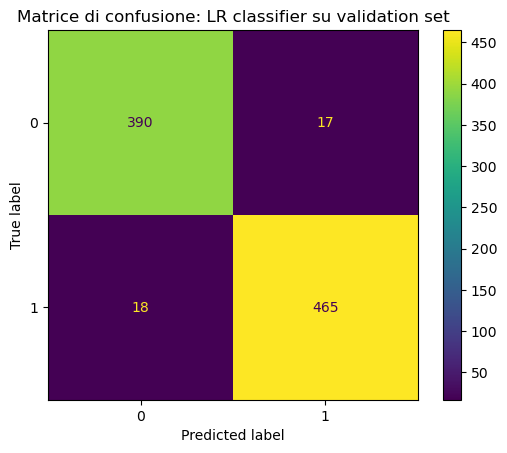

In [244]:
# Procedo in maniera standard, usando pipeline e un misto tra regolarizzatore Ridge e Lasso con elasticnet
model_lr1 = LogisticRegressionCV(
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0,0.25,0.5,0.75,1.0],
    max_iter=2500,
    tol=0.001
)

scal = StandardScaler()

pipe_lr1 = Pipeline([('scaler',scal), ('model_lr1',model_lr1)])
pipe_lr1.fit(x_train, y_train)
y_pred_lr1 = pipe_lr1.predict(x_valid)

print("LR:", accuracy_score(y_valid, y_pred_lr1))
print(classification_report(y_valid, y_pred_lr1))

ConfusionMatrixDisplay.from_estimator(pipe_lr1, x_valid, y_valid)
plt.title('Matrice di confusione: LR classifier su validation set')


Notiamo subito che la matrice di confusione e' peggiore di quella ottenuta con le Random Forest, come previsto. Diamo un'occhiata ai coefficienti:

In [247]:
df_coef = pd.DataFrame((model_lr1.coef_.T),columns=['coefficients'],index=x_train.columns)
df_coef = df_coef.sort_values('coefficients', ascending=True)

<Axes: >

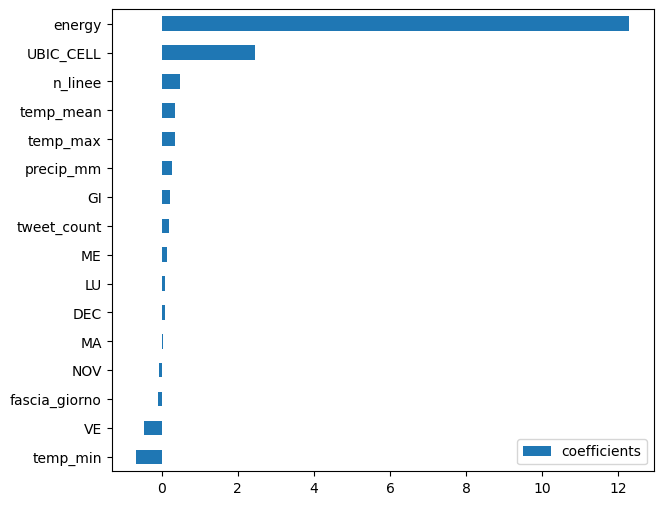

In [249]:
df_coef.plot.barh(figsize=(7,6))

E' interessante notare come in questo caso abbiamo un'ordine leggermente diverso per importanza rispetto alle Random Forest: qui il numero di tweet scende di molto cosi come la temperatura media, e addirittura la temperatura minima assume un peso negativo. Energia, numero di ubicazioni per cella e linee collegate alla cella rimangono invece sempre ai primi tre posti.

Proviamo ad usare GridSearchCV anche in questo caso:

In [253]:
# Creiamo un modello di Logistic Regression
model_lr2 = LogisticRegression(
    solver='saga',
)

scal = StandardScaler()
# Creiamo la pipeline con questo modello
pipe_lr2 = Pipeline([('scaler',scal), ('model_lr2',model_lr2)])

In [255]:
# Griglia di parametri per GridSearchCV
param_grid = {
    'model_lr2__penalty': ['elasticnet'],
    'model_lr2__C': np.logspace(-4, 4, 10),
    'model_lr2__l1_ratio': [0.001, 0.01, 0.1, 0.5, 0.75, 1],
    'model_lr2__max_iter': [1000, 2500, 3500],
    'model_lr2__tol': [1e-4, 1e-3, 1e-2]
}
cv = 5

In [257]:
# Creo il modello GridSearch con la funzione best_model creata prima
model_lr_grsc_acc, param_lr_acc = best_model(pipe_lr2, param_grid, x_train, y_train, cv=cv, scoring='accuracy')
model_lr_grsc_f1, param_lr_f1 = best_model(pipe_lr2, param_grid, x_train, y_train, cv=cv, scoring='f1')
model_lr_grsc_mcc, param_lr_mcc = best_model(pipe_lr2, param_grid, x_train, y_train, cv=cv, scoring='matthews_corrcoef')

In [259]:
# Stampo i parametri
print(param_lr_acc)
print(param_lr_f1)
print(param_lr_mcc)

{'model_lr2__C': 2.782559402207126, 'model_lr2__l1_ratio': 0.001, 'model_lr2__max_iter': 1000, 'model_lr2__penalty': 'elasticnet', 'model_lr2__tol': 0.001}
{'model_lr2__C': 2.782559402207126, 'model_lr2__l1_ratio': 0.001, 'model_lr2__max_iter': 1000, 'model_lr2__penalty': 'elasticnet', 'model_lr2__tol': 0.001}
{'model_lr2__C': 2.782559402207126, 'model_lr2__l1_ratio': 0.001, 'model_lr2__max_iter': 1000, 'model_lr2__penalty': 'elasticnet', 'model_lr2__tol': 0.001}


In [261]:
# Predico l'insieme di validazione
y_pred_lr_acc = model_lr_grsc_acc.predict(x_valid)
y_pred_lr_f1 = model_lr_grsc_f1.predict(x_valid)
y_pred_lr_mcc = model_lr_grsc_mcc.predict(x_valid)

Guardiamo lo score e la matrice di confusione dei vari modelli

In [264]:
print("LR accuracy:", accuracy_score(y_valid, y_pred_lr_acc))
print(classification_report(y_valid, y_pred_lr_acc))

print('matrice di confusione: RF classifier ottimizzato mcc su validation set')
print(confusion_matrix(y_valid, y_pred_lr_acc))

LR accuracy: 0.9595505617977528
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       407
           1       0.96      0.96      0.96       483

    accuracy                           0.96       890
   macro avg       0.96      0.96      0.96       890
weighted avg       0.96      0.96      0.96       890

matrice di confusione: RF classifier ottimizzato mcc su validation set
[[389  18]
 [ 18 465]]


In [266]:
print("LR accuracy:", accuracy_score(y_valid, y_pred_lr_f1))
print(classification_report(y_valid, y_pred_lr_f1))

print('matrice di confusione: RF classifier ottimizzato mcc su validation set')
print(confusion_matrix(y_valid, y_pred_lr_f1))

LR accuracy: 0.9595505617977528
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       407
           1       0.96      0.96      0.96       483

    accuracy                           0.96       890
   macro avg       0.96      0.96      0.96       890
weighted avg       0.96      0.96      0.96       890

matrice di confusione: RF classifier ottimizzato mcc su validation set
[[389  18]
 [ 18 465]]


In [268]:
print("LR accuracy:", accuracy_score(y_valid, y_pred_lr_mcc))
print(classification_report(y_valid, y_pred_lr_mcc))

print('matrice di confusione: RF classifier ottimizzato mcc su validation set')
print(confusion_matrix(y_valid, y_pred_lr_mcc))

LR accuracy: 0.9595505617977528
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       407
           1       0.96      0.96      0.96       483

    accuracy                           0.96       890
   macro avg       0.96      0.96      0.96       890
weighted avg       0.96      0.96      0.96       890

matrice di confusione: RF classifier ottimizzato mcc su validation set
[[389  18]
 [ 18 465]]


Provando anche diverse griglie di parametri si nota che i parametri migliori sono sempre gli stessi per tutte e tre le metriche: questo  ci fa capire che le classi sono poco sensibili alla metrica scelta, cosa che puo' essere dovuta dal fatto di avere classi bilanciate.

Scegliamo allora il modello con accuracy come metrica come modello migliore, anche se non cambia nulla dagli altri due. Procediamo a disegnare la ROC e a trovare la treshold migliore:

Procediamo come nel caso delle Random Forest

In [273]:
model_lr_best = model_lr_grsc_acc
param_lr_best = param_lr_acc

In [275]:
y_prob_lr_roc = model_lr_best.predict_proba(x_test)[:,1]

In [277]:
fpr_lr, tpr_lr, roc_th_lr = roc_curve(y_test, y_prob_lr_roc)
roc_auc_lr = auc(fpr_lr, tpr_lr)

Di nuovo troviamo la treshold che minimizza la distanza dal punto ottimale (TPR, FPR) = (1,0)

In [280]:
distance = np.sqrt((fpr_lr)**2 + (1-tpr_lr)**2)
index_min = np.argmin(distance)
best_roc_th_lr = roc_th_lr[index_min]

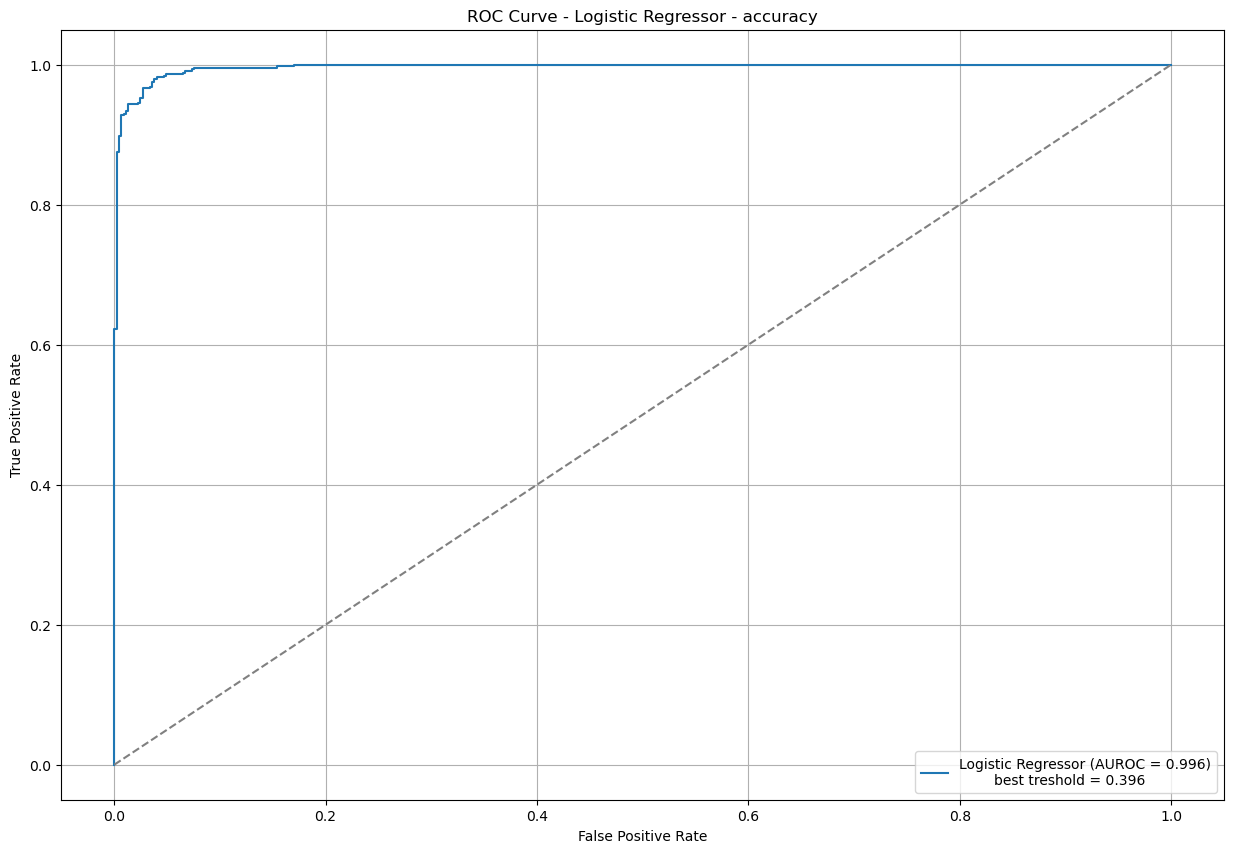

In [282]:
fig, ax = plt.subplots(figsize=(15, 10))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regressor (AUROC = {roc_auc_lr:.3f})\n\
        best treshold = {best_roc_th_lr:.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regressor - accuracy')
plt.legend()
plt.grid()

In [284]:
y_pred_lr = (y_prob_lr_roc >= best_roc_th_lr).astype(int)

LR con miglior treshold: 0.9708193041526375
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       448
           1       0.96      0.98      0.97       443

    accuracy                           0.97       891
   macro avg       0.97      0.97      0.97       891
weighted avg       0.97      0.97      0.97       891



Text(0.5, 1.0, 'Matrice di confusione: LR classifier con treshold migliore su test set')

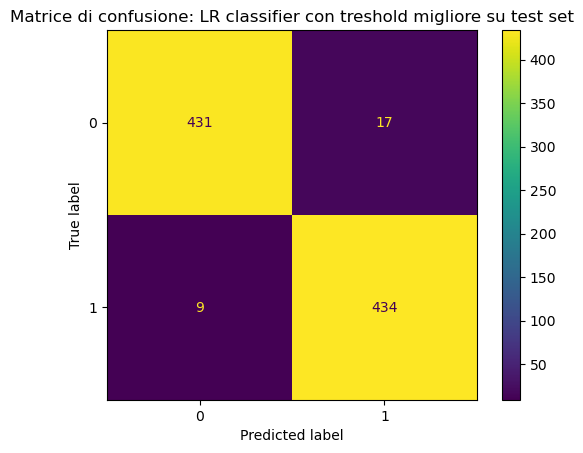

In [286]:
print("LR con miglior treshold:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)
plt.title('Matrice di confusione: LR classifier con treshold migliore su test set')

Notiamo che in questo caso la matrice di confusione milgiora, i falsi positivi sono rimasti gli stessi mentre si sono quasi dimezzati i falsi negativi.

Procediamo con la curva precision-recall

In [289]:
y_pred_lr_prrec = model_lr_best.predict_proba(x_test)[:,1]
pr_lr, rec_lr, prrec_th_lr = precision_recall_curve(y_test, y_pred_lr_prrec)

Anche qui trovo di nuovo la soglia migliore, ovvero quella che minimizza la distanza dal punto ottimale (REC, PREC) = (1,1)

In [292]:
distance = np.sqrt((1-rec_lr)**2 + (1-pr_lr)**2)
index_min = np.argmin(distance)
best_prrec_th_lr = prrec_th_lr[index_min]

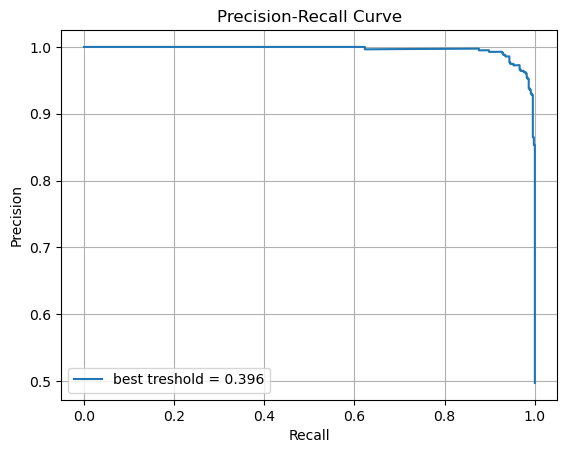

In [294]:
plt.plot(rec_lr, pr_lr, label=f'best treshold = {best_prrec_th_lr:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Anche in questo caso la treshold rimane la stessa della ROC. Questo e' probabilmente dovuto di nuovo al fatto che abbiamo un dataset estremamente bilanciato, dato che durante la EDA abbiamo scelto la mediana come soglia per separare celle ad alta e bassa energia.

Concludiamo riaddestrando il modello sull'insieme creato in precedenza che unisce train e validazione

In [298]:
pipe_lr2.set_params(**param_lr_best)
pipe_lr2.fit(x_valut, y_valut)

y_prob_fin_lr = pipe_lr2.predict_proba(x_test)[:,1]
y_pred_fin_lr = (y_prob_fin_lr >= best_roc_th_lr).astype(int)

LR con miglior treshold su train e validazione: 0.9696969696969697
              precision    recall  f1-score   support

           0       0.98      0.96      0.97       448
           1       0.96      0.98      0.97       443

    accuracy                           0.97       891
   macro avg       0.97      0.97      0.97       891
weighted avg       0.97      0.97      0.97       891



Text(0.5, 1.0, 'Matrice di confusione: LR classifier train + validazione con treshold migliore su test set')

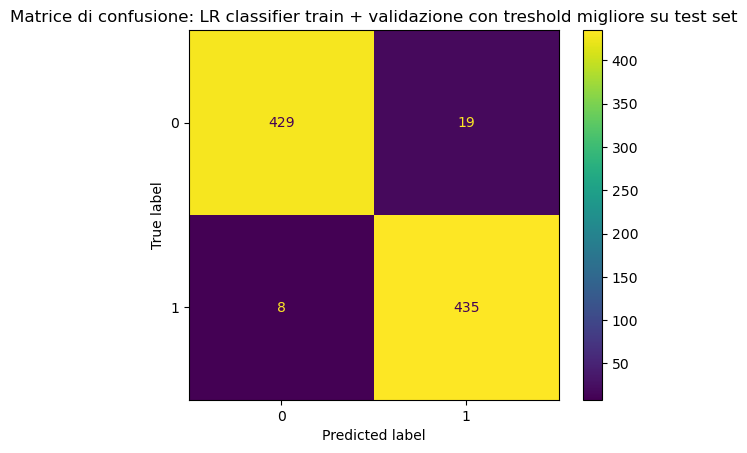

In [300]:
print("LR con miglior treshold su train e validazione:", accuracy_score(y_test, y_pred_fin_lr))
print(classification_report(y_test, y_pred_fin_lr))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_fin_lr)
plt.title('Matrice di confusione: LR classifier train + validazione con treshold migliore su test set')

Siamo riusciti a migliorare abbastanza il modello che usa la regressione logistica ma nonostante questo, come ci si aspettava, il modello con le Random Forest risulta essere migliore.

Modello migliore: model_rf_final

Treshold migliore: best_roc_th